In [1]:
import numpy as np
import os
import yaml
from pprint import pprint
from lomentum.loader import read_element
from lomentum.plotting import plotter
from lomentum.loader import register_user_module
from qdev_wrappers.pulse_building import atoms_ext 
from qcodes.instrument.base import InstrumentBase
from qdev_wrappers.station_configurator import StationConfigurator
from qdev_wrappers.customised_instruments.interfaces.microwave_source_interface import SimulatedMicrowaveSourceInterface, SGS100AMicrowaveSourceInterface
from qdev_wrappers.customised_instruments.interfaces.AWG_interface import SimulatedAWGInterface, AWG5014Interface
from qdev_wrappers.customised_instruments.composite_instruments.parametric_sequencer.parametric_sequencer import ParametricSequencer
from qdev_wrappers.customised_instruments.composite_instruments.sidebander.sidebander import Sidebander
register_user_module(atoms_ext)

/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/logger.py:16: UserWarning: The logger.py of qdev-wrappers is deprecated and will be removed soon. Please use the logger of QCoDeS instead.
  warnings.warn('The logger.py of qdev-wrappers is deprecated and will be '
/Users/natalie/Documents/PhD/Qdev/QdevWrappers/qdev_wrappers/station_configurator.py:21: UserWarning: ruamel yaml not found station configurator is falling back to pyyaml. It's highly recommended to install ruamel.yaml. This fixes issues with scientific notation and duplicate instruments in the YAML file
  warnings.warn("ruamel yaml not found station configurator is falling back to pyyaml. "


In [2]:
def print_params(instr):
    print('\n')
    print(instr.name.upper())
    for k, v in instr.parameters.items():
        if k != 'IDN':
            print(k, ': ', v())
    for k, v in instr.submodules.items():
        if isinstance(v, InstrumentBase):
            print_params(v)

## Now for some advanced stuff
 
Lets imagine we want to use one microwave source (or heterodyne source) and two awg channels to create multiple sidebands (we'll go with 2 to keep things simple). We'd need multiple sidebanders... Let's go ahead and set these up 

In [3]:
with open('multiqubit_sidebanding_element.yaml') as f:
    yf = yaml.safe_load(f)
    template_element = read_element(yf)

In [4]:
real_instruments_present = False

In [5]:
if real_instruments_present:
    sc = StationConfigurator()
    awg = sc.load_instrument('AWG5014')
    microwave_source = sc.load_instrument('SGS100A')
    awg_if = AWG5014Interface('awg', awg)
    carrier_if = SGS100AMicrowaveSourceInterface('source')
else:
    awg_if = SimulatedAWGInterface('awg')
    carrier_if = SimulatedMicrowaveSourceInterface('source')
awg_if.to_default()
carrier_if.to_default()
ps = ParametricSequencer('ps', awg_if)

sidebander_0 = Sidebander('Q0', ps, carrier_if, pulse_building_prepend=True)
sidebander_1 = Sidebander('Q1', ps, carrier_if, pulse_building_prepend=True)

uploading
running


/Users/natalie/Documents/PhD/Qdev/lomentum/lomentum/plotting.py:252: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=800.0, top=800.0
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])
/Users/natalie/Documents/PhD/Qdev/lomentum/lomentum/plotting.py:252: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  ax.set_ylim([ymin-0.05*yrange, ymax+0.2*yrange])


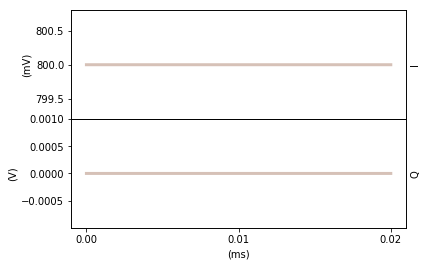

In [6]:
context = {**sidebander_0.generate_context(), **sidebander_1.generate_context()}
ps.change_sequence(template_element=template_element, context=context)

In [7]:
print_params(sidebander_0)
print_params(sidebander_1)



Q0
frequency :  6000000000.0
carrier_power :  -10
carrier_frequency :  6000000000.0
sideband_frequency :  0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


Q1
frequency :  6000000000.0
carrier_power :  -10
carrier_frequency :  6000000000.0
sideband_frequency :  0
I_offset :  0
Q_offset :  0
gain_offset :  0
phase_offset :  0
amplitude :  0.8
status :  1


In [ ]:
sidebander_0.frequency()